In [16]:
import os
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow import keras
from keras import layers, models
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from collections import Counter
import keras
from keras import models
from keras import layers
import visualkeras 
from PIL import ImageFont
from PIL import ImageDraw

In [17]:
SAMPLE_RATE = 22050
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
SEGMENT_DURATION = 5  # in seconds
NUM_SEGMENTS = 10
DATASET_PATH = "dataset_wav"

In [18]:

def augment_audio(signal, sr):
    augmented = []

    # Pitch shifting
    try:
        steps = random.randint(-5, 5)
        shifted = librosa.effects.pitch_shift(signal, sr=sr, n_steps=steps)
        augmented.append(shifted)
    except Exception as e:
        print(f"Pitch-shift error: {e}")

    # Add noise
    noise = signal + 0.005 * np.random.randn(len(signal))
    augmented.append(noise)

    return augmented


In [19]:
def extract_spectrogram(signal, sr=SAMPLE_RATE):
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    log_spec = librosa.power_to_db(mel_spec)
    return log_spec

In [20]:
# def load_dataset(dataset_path):
#     features = []
#     labels = []

#     num_samples_per_segment = int(SAMPLE_RATE * SEGMENT_DURATION / NUM_SEGMENTS)
#     expected_length = math.ceil(num_samples_per_segment / HOP_LENGTH)

#     for dirpath, _, filenames in os.walk(dataset_path):
#         if dirpath != dataset_path:
#             label = os.path.basename(dirpath)
#             print(f"Processing label: {label}")
#             for filename in filenames:
#                 if filename.endswith(".wav"):
#                     file_path = os.path.join(dirpath, filename)
#                     signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

#                     for s in range(NUM_SEGMENTS):
#                         start = num_samples_per_segment * s
#                         end = start + num_samples_per_segment
#                         segment = signal[start:end]

#                         if len(segment) < num_samples_per_segment:
#                             continue

#                         spec = extract_spectrogram(segment, sr)
#                         spec = spec.T  # shape: (time, n_mels)

#                         if spec.shape[0] == expected_length:
#                             features.append(spec.tolist())
#                             labels.append(label)

#                     # Augmentasi
#                     augmented_signals = augment_audio(signal, sr)
#                     for aug in augmented_signals:
#                         for s in range(NUM_SEGMENTS):
#                             start = num_samples_per_segment * s
#                             end = start + num_samples_per_segment
#                             segment = aug[start:end]

#                             if len(segment) < num_samples_per_segment:
#                                 continue

#                             spec = extract_spectrogram(segment, sr)
#                             spec = spec.T

#                             if spec.shape[0] == expected_length:
#                                 features.append(spec.tolist())
#                                 labels.append(label)

#     return np.array(features), np.array(labels)

def load_dataset(dataset_path, segment_duration=5):
    features = []
    labels = []
    num_samples = int(SAMPLE_RATE * segment_duration)

    for dirpath, dirnames, filenames in os.walk(dataset_path):
        if dirpath != dataset_path:
            label = os.path.basename(dirpath)
            print(f"Processing: {label}")

            for file_name in filenames:
                if file_name.endswith(".wav"):
                    file_path = os.path.join(dirpath, file_name)
                    try:
                        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                        for s in range(NUM_SEGMENTS):
                            start = num_samples * s
                            end = start + num_samples

                            if end <= len(signal):
                                segment = signal[start:end]
                                log_spec = extract_spectrogram(segment)
                                if log_spec is not None:
                                    features.append(log_spec)
                                    labels.append(label)

                        augmented_signals = augment_audio(signal, sr)
                        for aug in augmented_signals:
                            for s in range(NUM_SEGMENTS):
                                start = num_samples * s
                                end = start + num_samples
                                if end <= len(aug):
                                    segment = aug[start:end]
                                    log_spec = extract_spectrogram(segment)
                                    if log_spec is not None:
                                        features.append(log_spec)
                                        labels.append(label)

                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

    # Padding/trimming spectrograms to same shape
    max_len = max(spec.shape[1] for spec in features)
    padded_features = [np.pad(spec, ((0, 0), (0, max_len - spec.shape[1])), mode='constant') for spec in features]

    return np.array(padded_features), np.array(labels)


In [21]:
X, y = load_dataset(DATASET_PATH)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X = X[..., np.newaxis]

Processing: Ardhito Pramono_Dancing In September
Processing: Ed Sheeran_Supermarket Flowers
Processing: GANGGA_Whiskey Bottle
Processing: Giveon_Heartbreak Anniversary
Processing: Gracie Abrams_That’s So True
Processing: Keshi_UNDERSTAND
Processing: Labrinth_Jealous
Processing: Lady Gaga_Die With A Smile
Processing: Lauv_First Heartbreak
Processing: Lukas Graham_Love Someone
Processing: Rich Brian_100 Degrees
Processing: Ricky Montgomery_This December


In [22]:
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

In [23]:
input_shape = X.shape[1:]  # (time, mels, 1)
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(24, (5, 5), activation="relu"),
    layers.MaxPooling2D((4, 4), strides=(2, 2), padding="same"),
    layers.BatchNormalization(),

    layers.Conv2D(48, (5, 5), activation="relu"),
    layers.MaxPooling2D((4, 4), strides=(2, 2), padding="same"),
    layers.BatchNormalization(),

    layers.Conv2D(48, (5, 5), activation="relu", padding="same"),
    layers.MaxPooling2D((4, 4), strides=(2, 2), padding="same"),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(label_encoder.classes_), activation="softmax")
])

In [24]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

font = ImageFont.truetype("arial.ttf", 12)
img = visualkeras.layered_view(model, legend=True, font=font)  
img.save("model_visualization.png")
img.show()
model.summary()

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.2607 - loss: 2.6282 - val_accuracy: 0.0764 - val_loss: 4.7531 - learning_rate: 1.0000e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.4935 - loss: 1.5225 - val_accuracy: 0.0833 - val_loss: 5.5319 - learning_rate: 1.0000e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.6908 - loss: 0.9714 - val_accuracy: 0.0764 - val_loss: 5.1362 - learning_rate: 1.0000e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.7437 - loss: 0.7403 - val_accuracy: 0.0972 - val_loss: 3.7374 - learning_rate: 1.0000e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.9008 - loss: 0.4395 - val_accuracy: 0.1736 - val_loss: 2.8822 - learning_rate: 1.0000e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.9042 - loss: 0.3360 - val_accuracy: 0.2847 - val_loss: 2.2654 - learning_rate: 1.0000e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 124, 212, 24)   │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 106, 24)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 106, 24)    │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 58, 102, 48)    │        28,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 29, 51, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 51, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 51, 48)     │        57,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 26, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 15, 26, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,859,094 (14.72 MB)

 Trainable params: 1,286,284 (4.91 MB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 2,572,570 (9.81 MB)

In [30]:
score = model.evaluate(x_test, y_test)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9453 - loss: 0.3410
Test Loss: 0.347065269947052
Test Accuracy: 0.9375


In [31]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Predicted classes:", y_pred_classes)
print("True classes:", y_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted classes: [ 1  5  8  0  5  6  5 10  5 11  6  6  6  5  3  9  1  2  2  8 10  0  1  3
  6  0  2 10  7  8 11  7  9  7 11  5  2  8  5  1  4  4  4  3  6  0  7  7
  2 10 10  4  0  3  8 11  3  1  5 10  2  4  5  3  6  4  3  2  3  5 11 11
  8  3  9  1  9  2  5  2  3  9  6 10  1  3  4  4  2  1  7 10  6 10  5  4
  0  9  3  0  3  8  6  7  8  6  3 11  8  0  9  5  1  0  1  7  6  8  9  3
  0  3  9  5  9  2  6  2  5  8 10  2  2  6 11  3  0  0  1  4  2  1  3  8]
True classes: [ 1  5  8  0  5  6  5 10  5 11  0  6  6  5  3  9  1  2  2  8 10  0  1  3
  6  0  2 10  7  8 11  7  9  7 11  5  2  8  5  1  4  4  4  3  6  0  7  7
  6 10 10  4  0  3  8 11  3  1  5 10  6  4  5  3  1  4  3  2  3  5 11 11
  8  3  9  1  9  9  5  2  3  9  6 10  1  3  4  4  9  1  7 10  6 10  5  4
  0  9  3  0  3  8  6  7  8  6  3 11  8  0  9  5  1  0  1  7  6  8  9  3
  0  3  9  5  9  2  1  1  0  8 10  2  2  6 11  3  0  0  1  4  2  1  3  8]
Classification Report:
                            

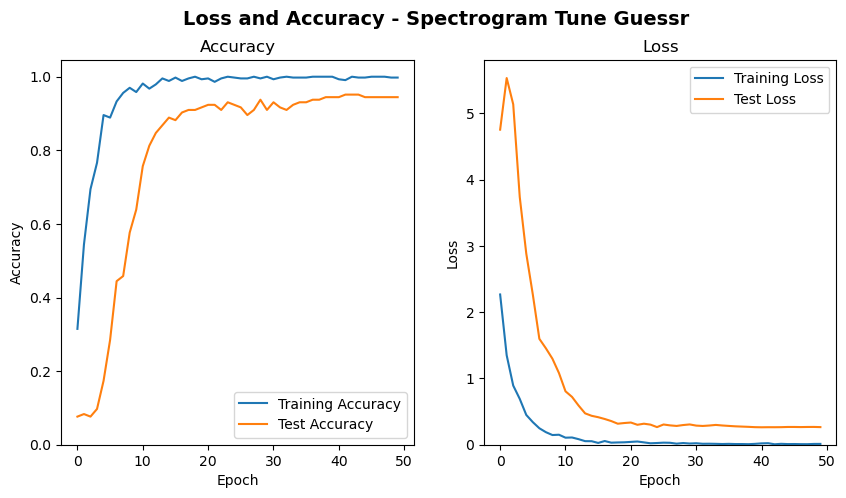

In [32]:
acc = history.history['accuracy']  
val_acc = history.history['val_accuracy'] 

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.suptitle("Loss and Accuracy - Spectrogram Tune Guessr", fontsize=14, fontweight='bold')  

plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Test Accuracy")
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Test Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.savefig('spectrogram_loss_accuracy.png')
plt.show()

In [33]:
def predict_song_spectrogram(file_path):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    segment_samples = int(SAMPLE_RATE * 5)
    num_segments = math.ceil(len(signal) / segment_samples)

    predictions = []

    for s in range(num_segments):
        start = segment_samples * s
        end = start + segment_samples
        segment = signal[start:end]

        if len(segment) < segment_samples:
            segment = np.pad(segment, (0, segment_samples - len(segment)), mode='constant')

        log_spec = extract_spectrogram(segment)
        if log_spec is not None:
            max_len = model.input_shape[2]
            padded_spec = np.pad(log_spec, ((0, 0), (0, max_len - log_spec.shape[1])), mode='constant')
            padded_spec = padded_spec[np.newaxis, ..., np.newaxis]  # shape: (1, n_mels, time, 1)

            prediction = model.predict(padded_spec)
            predicted_label = np.argmax(prediction)
            predictions.append(predicted_label)

    most_common_label = Counter(predictions).most_common(1)[0][0]
    predicted_song = label_encoder.inverse_transform([most_common_label])[0]

    try:
        artist, song = predicted_song.split("_")
    except ValueError:
        artist, song = predicted_song, "Unknown Title"

    print(f"Predicted Artist: {artist}")
    print(f"Predicted Song: {song}")
    return artist, song

new_file_path = "dataset_wav/Ardhito Pramono_Dancing In September/Ardhito Pramono_Dancing In September_segment_3.wav"
predicted_artist, predicted_song = predict_song_spectrogram(new_file_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Artist: Ardhito Pramono
Predicted Song: Dancing In September


In [34]:
model.save("spectrogram_model.keras")